In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates

plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
df = pd.read_csv('../data/ihe_testing_casecounts_fall2020.csv', dtype={'ipeds_id':str})
ll = pd.read_csv('../data/county_level_data.csv', dtype={'fips':str})
ipeds_df = pd.read_csv('../data/ipeds_data.csv', encoding='latin8', dtype={'ipeds_id':str,
                                                                           'Fips County code (HD2019)':str})

rename_ipeds = {'Institution Name':'name', 'Latitude location of institution (HD2019)':'lat',
                'Longitude location of institution (HD2019)':'lon', 'Level of Institution':'institution_level',
                'Control of institution':'institution_control', 'Institution Size':'institution_size_bin',
                'Total enrollment (DRVEF2018)':'enrollment_total','Fips County code (HD2019)':'fips',
                'Full-time enrollment (DRVEF2018)':'enrollment_fulltime', 
                'Endowment per FTE':'endowment_per_fte',
                'Percent admitted - total (DRVADM2019)':'percent_admitted'}

ipeds_df = ipeds_df.rename(columns=rename_ipeds)
ipeds_df = ipeds_df[['ipeds_id','fips', 'lat', 'lon', 'institution_level', 'institution_control',
                     'institution_size_bin', 'enrollment_total', 'enrollment_fulltime',
                     'endowment_per_fte', 'percent_admitted']]
ipeds_df['fips'] = ("0"+ipeds_df['fips'].str[:]).str[-5:]
df = df.merge(ipeds_df[['ipeds_id','fips','enrollment_fulltime','enrollment_total']], how='left', on='ipeds_id')

In [3]:
# get counties of schools that do / don't test frequently

In [4]:
ihe_df = df.groupby(['college','ipeds_id','fips',
                     'enrollment_fulltime','enrollment_total']).agg({'total_tests':'sum',
                                                                     'positive_tests':'sum'}).reset_index()

In [5]:
cumul_only = df.loc[~df['notes'].isna()].reset_index().iloc[:,1:].copy()
cumul_tests = cumul_only.loc[cumul_only['notes'].str.contains('cumulative_tests')].reset_index().iloc[:,1:].copy()
cumul_cases = cumul_only.loc[cumul_only['notes'].str.contains('cumulative_cases')].reset_index().iloc[:,1:].copy()
cumul_cases['positive_tests'] = [int(i[1]) for i in cumul_cases['notes'].str.split('cumulative_cases = ')]
cumul_tests['total_tests'] = [int(i[1]) for i in cumul_tests['notes'].str.split('cumulative_tests = ')]
# cumul_ipeds = np.unique(cumul_cases['ipeds_id'].to_list())
df_temp = df.copy()
df_temp['gran'] = df_temp['total_tests'] + df_temp['positive_tests']
df_temp = df_temp.groupby(['college','ipeds_id']).agg({'gran':'sum'}).reset_index()
cumul_ipeds = df_temp.loc[df_temp['gran']<=0]['ipeds_id'].values
# cumul_ipeds = np.unique(cumul_tests['ipeds_id'].to_list() + cumul_cases['ipeds_id'].to_list())

In [6]:
times_df = ihe_df.loc[~ihe_df['ipeds_id'].isin(cumul_ipeds)].reset_index().iloc[:,1:].copy()
cumul_df = df.loc[df['ipeds_id'].isin(cumul_ipeds)][['college', 'ipeds_id', 'fips',
                  'enrollment_fulltime','enrollment_total']].drop_duplicates().reset_index().iloc[:,1:].copy()
cumul_df = cumul_df.merge(cumul_tests[['ipeds_id','total_tests']],how='left',on='ipeds_id')
cumul_df = cumul_df.merge(cumul_cases[['ipeds_id','positive_tests']],how='left',on='ipeds_id')

dfw = pd.concat([times_df,cumul_df]).reset_index().iloc[:,1:].copy()
dfw['total_tests'] = np.nan_to_num(dfw['total_tests'])

In [7]:
dfw['total_tests_per_1000_fulltime'] = (dfw['total_tests']/dfw['enrollment_fulltime']) * 1000
dfw['total_tests_per_1000_enrollment'] = (dfw['total_tests']/dfw['enrollment_total']) * 1000
dfw['positive_tests_per_1000_fulltime'] = (dfw['positive_tests']/dfw['enrollment_fulltime']) * 1000
dfw['positive_tests_per_1000_enrollment'] = (dfw['positive_tests']/dfw['enrollment_total']) * 1000

In [8]:
min_tests = 1000
var = 'total_tests'
nontest_fips = list(dfw.loc[dfw[var]<=min_tests]['fips'].unique())
yestest_fips = list(dfw.loc[dfw[var]>min_tests]['fips'].unique())
nontest_fips = [i for i in nontest_fips if i not in yestest_fips]

ll_non = ll.loc[ll['fips'].isin(nontest_fips)].reset_index().iloc[:,1:].copy()
ll_yes = ll.loc[ll['fips'].isin(yestest_fips)].reset_index().iloc[:,1:].copy()

ll_non = ll_non.loc[(ll_non['date']>'2020-06-30')&(ll_non['date']<'2020-12-20')].copy()
ll_yes = ll_yes.loc[(ll_yes['date']>'2020-06-30')&(ll_yes['date']<'2020-12-20')].copy()

In [9]:
def get_ci(df, col, gb_col='date', percentile='95'):
    if percentile == '95':
        cival = 1.96

    df_stats = df.groupby(gb_col)[col].agg([np.nanmean,'count',np.nanstd])
    ci95_hi = []
    ci95_lo = []
    for i in df_stats.index:
        m, c, s = df_stats.loc[i]
        ci95_hi.append(m + cival*s/np.sqrt(c))
        ci95_lo.append(m - cival*s/np.sqrt(c))
    df_stats['ci95_hi'] = ci95_hi
    df_stats['ci95_lo'] = ci95_lo

    return df_stats

In [10]:
ll_non_cases = get_ci(ll_non,'new_cases_per_1000_county').reset_index()
ll_yes_cases = get_ci(ll_yes,'new_cases_per_1000_county').reset_index()

ll_non_death = get_ci(ll_non,'new_deaths_per_1000_county').reset_index()
ll_yes_death = get_ci(ll_yes,'new_deaths_per_1000_county').reset_index()

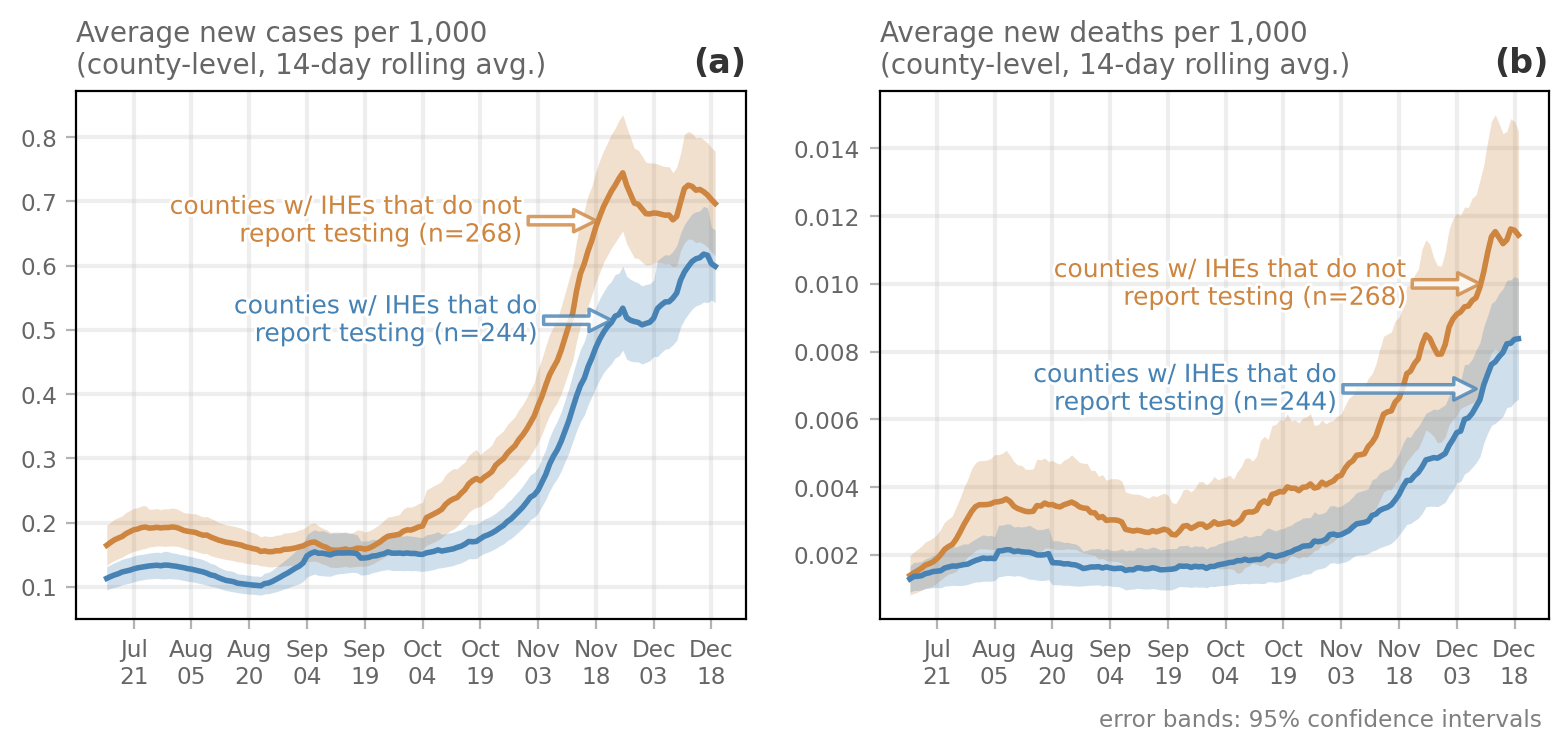

In [11]:
yes_col = 'steelblue'
non_col = 'peru'
wid = 14

fig, ax = plt.subplots(1,2,figsize=(9.5,3.5),dpi=200,sharex=True)

x_yes_death = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in ll_yes_death['date'].values]
x_non_death = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in ll_non_death['date'].values]
x_yes_cases = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in ll_yes_cases['date'].values]
x_non_cases = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in ll_non_cases['date'].values]

yestest_lab = 'counties w/ IHEs that do\nreport testing (n=%i)'%len(yestest_fips)
nontest_lab = 'counties w/ IHEs that do not\nreport testing (n=%i)'%len(nontest_fips)

ax[0].plot(x_non_cases, ll_non_cases['nanmean'].rolling(window=wid).mean().values, color=non_col,lw=2)
ax[0].plot(x_yes_cases, ll_yes_cases['nanmean'].rolling(window=wid).mean().values, color=yes_col,lw=2)
ax[1].plot(x_non_death, ll_non_death['nanmean'].rolling(window=wid).mean().values, color=non_col,lw=2)
ax[1].plot(x_yes_death, ll_yes_death['nanmean'].rolling(window=wid).mean().values, color=yes_col,lw=2)

ax[0].fill_between(x_non_cases, ll_non_cases['ci95_lo'].rolling(window=wid).mean().values,
             ll_non_cases['ci95_hi'].rolling(window=wid).mean().values, alpha=0.25,color=non_col, lw=0)
ax[0].fill_between(x_yes_cases, ll_yes_cases['ci95_lo'].rolling(window=wid).mean().values,
             ll_yes_cases['ci95_hi'].rolling(window=wid).mean().values, alpha=0.25,color=yes_col, lw=0)
ax[1].fill_between(x_non_death, ll_non_death['ci95_lo'].rolling(window=wid).mean().values,
             ll_non_death['ci95_hi'].rolling(window=wid).mean().values, alpha=0.25,color=non_col, lw=0)
ax[1].fill_between(x_yes_death, ll_yes_death['ci95_lo'].rolling(window=wid).mean().values,
             ll_yes_death['ci95_hi'].rolling(window=wid).mean().values, alpha=0.25,color=yes_col, lw=0)

ax[0].annotate(nontest_lab, xy=(x_non_cases[-32], 0.67), xytext=(x_non_cases[-51], 0.67),
             arrowprops=dict(fc='w', ec=non_col, width=3, lw=1.25, headwidth=8, headlength=8, alpha=0.8),
             ha='right',va='center',fontsize=9,color=non_col,zorder=2,
             path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Normal()])
ax[0].annotate(yestest_lab, xy=(x_yes_cases[-28], 0.515), xytext=(x_yes_cases[-47], 0.515),
             arrowprops=dict(fc='w', ec=yes_col, width=3, lw=1.25, headwidth=8, headlength=8, alpha=0.8),
             ha='right',va='center',fontsize=9,color=yes_col,zorder=2,
             path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Normal()])
ax[1].annotate(nontest_lab, xy=(x_non_cases[-11], 0.010), xytext=(x_non_cases[-30], 0.010),
             arrowprops=dict(fc='w', ec=non_col, width=3, lw=1.25, headwidth=8, headlength=8, alpha=0.8),
             ha='right',va='center',fontsize=9,color=non_col,zorder=2,
             path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Normal()])
ax[1].annotate(yestest_lab, xy=(x_yes_cases[-12], 0.0069), xytext=(x_yes_cases[-48], 0.0069),
             arrowprops=dict(fc='w', ec=yes_col, width=3, lw=1.25, headwidth=8, headlength=8, alpha=0.8),
             ha='right',va='center',fontsize=9,color=yes_col,zorder=2,
             path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Normal()])

ax[0].set_title('Average new cases per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.4',x=0,ha='left', fontsize='medium')
ax[1].set_title('Average new deaths per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.4',x=0,ha='left', fontsize='medium')
ax[1].text(0.99, -0.17, 'error bands: 95% confidence intervals', ha='right', va='top',
           transform=ax[1].transAxes, color='.5', fontsize='small')

letts = ["(a)","(b)"]
for ai, a in enumerate(fig.axes):
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7',labelsize='small')
    a.set_xticks(x_yes_death[20::15])
    a.set_xticklabels(["{:%b\n%d}".format(i) for i in x_yes_death[20::15]],fontsize='small')
    a.text(1.0, 1.02, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')

plt.savefig('../figs/pngs/cases_deaths_FIPS_yestest_nontest.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/cases_deaths_FIPS_yestest_nontest.pdf',bbox_inches='tight')
plt.show()

In [12]:
regions_dict = {'Plains':['Iowa', 'Kansas', 'Minnesota', 'Missouri',
                          'Nebraska', 'North Dakota', 'South Dakota'],
                'Rocky Mountains':['Colorado', 'Idaho', 'Montana', 'Utah', 'Wyoming'],
                'Far West':['Alaska', 'California', 'Hawaii', 'Nevada', 'Oregon', 'Washington'],
                'Southwest':['Arizona', 'New Mexico', 'Oklahoma', 'Texas'],
                'Great Lakes':['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin'],
                'Southeast':['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Kentucky', 'Louisiana',
                             'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee',
                             'Virginia', 'West Virginia'],
                'New England':['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
                               'Rhode Island', 'Vermont'],
                'Mid East':['Delaware', 'District of Columbia', 'Maryland', 'New Jersey',
                            'New York', 'Pennsylvania']}

reg_names = [[list(regions_dict.keys())[i]]*len(list(regions_dict.values())[i]) for i in range(len(regions_dict))]
reg_state = list(regions_dict.values())

flat_names = [item for sublist in reg_names for item in sublist]
flat_state = [item for sublist in reg_state for item in sublist]
region_df = pd.DataFrame({'region':flat_names,'state':flat_state})

In [13]:
df = df.merge(region_df, how='left', on='state')
ll = ll.merge(region_df, how='left', on='state')

In [14]:
dfr = df.groupby(['date','region']).agg({'positive_tests':'sum',
                                         'enrollment_fulltime':'sum',
                                         'ipeds_id':'count'}).reset_index()
dfr['positive_tests_per_1000'] = (dfr['positive_tests'] / dfr['enrollment_fulltime']) * 1000

In [15]:
llr = ll.groupby(['date','region']).agg({'new_cases_county':'sum',
                                         'county_population':'sum',
                                         'fips':'count'}).reset_index()
llr['new_cases_county_per_1000'] = (llr['new_cases_county'] / llr['county_population']) * 1000
llr = llr.loc[(llr.date>'2020-07-31')&(llr.date<'2020-12-17')].copy()

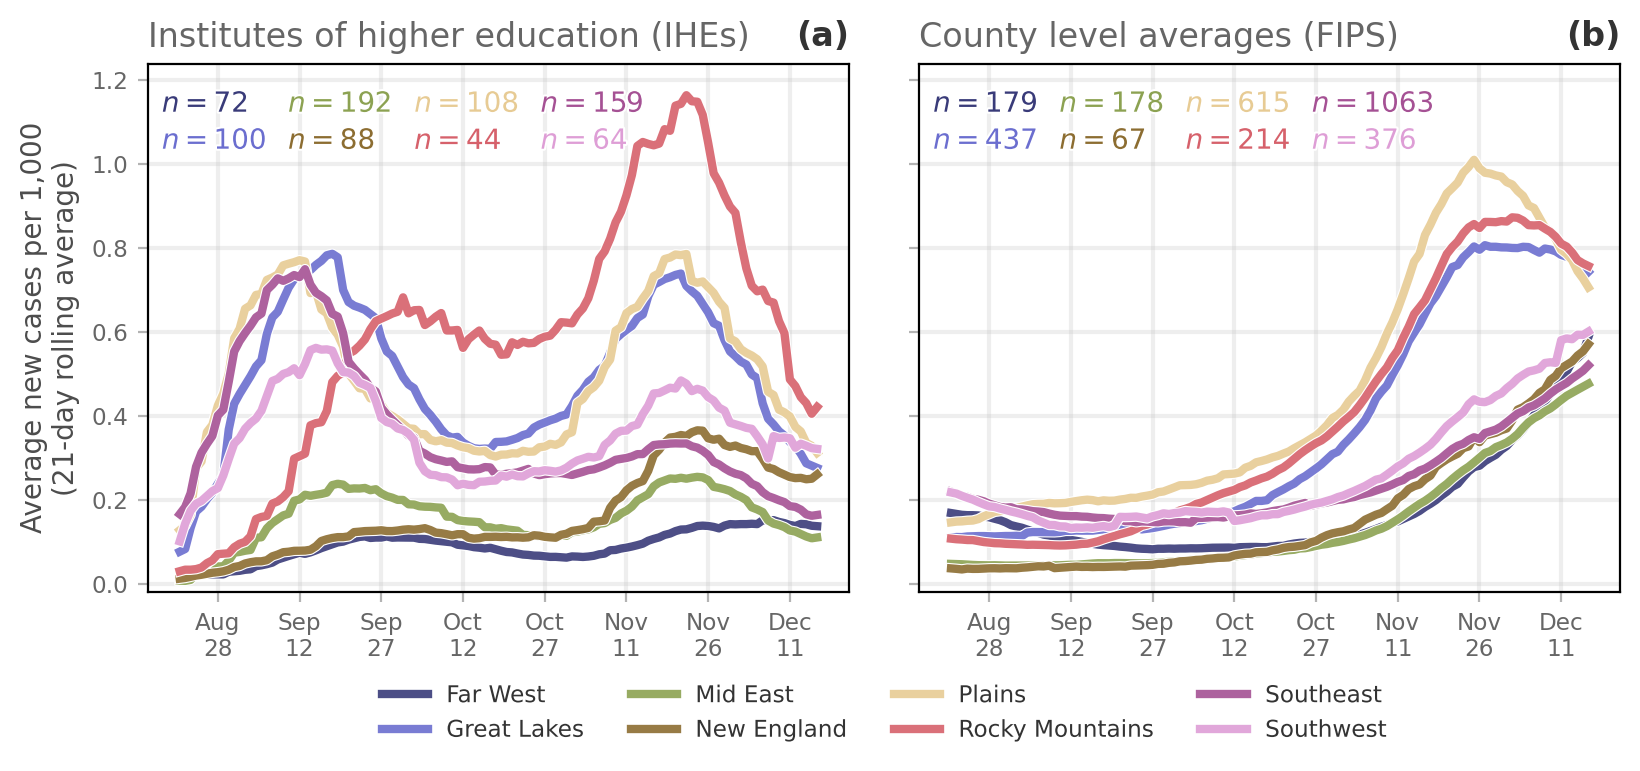

In [16]:
wid = 21

fig, ax = plt.subplots(1,2,figsize=(9.5,3.5),dpi=200,sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.1)
cols = plt.cm.tab20b(np.linspace(0,1,dfr.region.nunique()))

ycurr = 0.95
xcurr = 0.02

for ri,r in enumerate(dfr.region.unique()):
    dfr_i = dfr.loc[dfr['region']==r].copy()
    llr_i = llr.loc[llr['region']==r].copy()
    x_dfr = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dfr_i['date'].values]
    x_llr = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in llr_i['date'].values]
    ax[0].plot(x_dfr, dfr_i['positive_tests_per_1000'].rolling(window=wid).mean().values,
             color='w',lw=3.8)
    ax[0].plot(x_dfr, dfr_i['positive_tests_per_1000'].rolling(window=wid).mean().values,
             color=cols[ri],label=r,lw=3,alpha=0.9)
    ax[1].plot(x_llr, llr_i['new_cases_county_per_1000'].rolling(window=wid).mean().values,
             color='w',lw=3.8)
    ax[1].plot(x_llr, llr_i['new_cases_county_per_1000'].rolling(window=wid).mean().values,
             color=cols[ri],lw=3,alpha=0.9)
    ax[0].text(xcurr, ycurr, "$n=%i$"%int(np.mean(dfr_i['ipeds_id'])), ha='left', va='top',
               transform=ax[0].transAxes, color=cols[ri],
               path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),path_effects.Normal()])
    ax[1].text(xcurr, ycurr, "$n=%i$"%int(np.mean(llr_i['fips'])), ha='left', va='top',
               transform=ax[1].transAxes, color=cols[ri],
               path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),path_effects.Normal()])
    ycurr -= 0.07
    if ri % 2 != 0:
        ycurr = 0.95
        xcurr += 0.18

ax[0].set_ylabel('Average new cases per 1,000\n(%i-day rolling average)'%(wid), color='.3')
ax[0].set_title('Institutes of higher education (IHEs)', color='.4',x=0,ha='left',fontsize='large')
ax[1].set_title('County level averages (FIPS)', color='.4',x=0,ha='left',fontsize='large')
l = ax[0].legend(ncol=4,framealpha=0.0,fontsize='small',bbox_to_anchor=[1.05,-0.135],loc=9)
for text in l.get_texts():
    text.set_color('.2')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

letts = ["(a)","(b)"]
for ai, a in enumerate(fig.axes):
    a.set_xticks(x_llr[27::15])
    a.set_xticklabels(["{:%b\n%d}".format(i) for i in x_llr[27::15]],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7',labelsize='small')
    a.set_ylim(-0.02,1.24)
    a.text(1.0, 1.02, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')

    
plt.savefig('../figs/pngs/cases_IHE_FIPS_regions.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/cases_IHE_FIPS_regions.pdf',bbox_inches='tight')

plt.show()

In [17]:
geo_dfx = ipeds_df.loc[ipeds_df['ipeds_id'].isin(cumul_df['ipeds_id'].unique())][['ipeds_id','lat','lon']].copy()
geo_dfx = gpd.GeoDataFrame(geo_dfx,
                           geometry=gpd.points_from_xy(geo_dfx.lon, geo_dfx.lat))[['ipeds_id','geometry']]
geo_dfx = geo_dfx.reset_index().iloc[:,1:]
geo_dfx.crs = {"init": "epsg:4326"}
geo_dfx = geo_dfx.to_crs(epsg=3395)

geo_dfx = geo_dfx.merge(ipeds_df[['ipeds_id','enrollment_total']])

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [18]:
geo_df = ipeds_df.loc[ipeds_df['ipeds_id'].isin(times_df['ipeds_id'].values)][['ipeds_id','lat','lon']].copy()
geo_df = gpd.GeoDataFrame(geo_df, geometry=gpd.points_from_xy(geo_df.lon, geo_df.lat))[['ipeds_id','geometry']]
geo_df = geo_df.reset_index().iloc[:,1:]
geo_df.crs = {"init": "epsg:4326"}
geo_df = geo_df.to_crs(epsg=3395)

geo_df = geo_df.merge(ipeds_df[['ipeds_id','enrollment_total']])

xx = geo_df.merge(df[['ipeds_id','region']].drop_duplicates(),how='left',on='ipeds_id')
xx.loc[xx.region.isna(),'region'] = 'na'
xx = xx.loc[xx['region']!='na'].copy()

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [19]:
county_shp = gpd.read_file('../data/tl_2017_us_state/')
dat_shp = county_shp.loc[~(county_shp['STATEFP'].isin(['78','60','72','66','02','15','69']))].copy()
# dat_shp = dat_shp.rename(columns={'GEOID':'fips'})

dat_shp.crs = {"init": "epsg:4326"}
dat_shp = dat_shp.to_crs(epsg=3395)

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


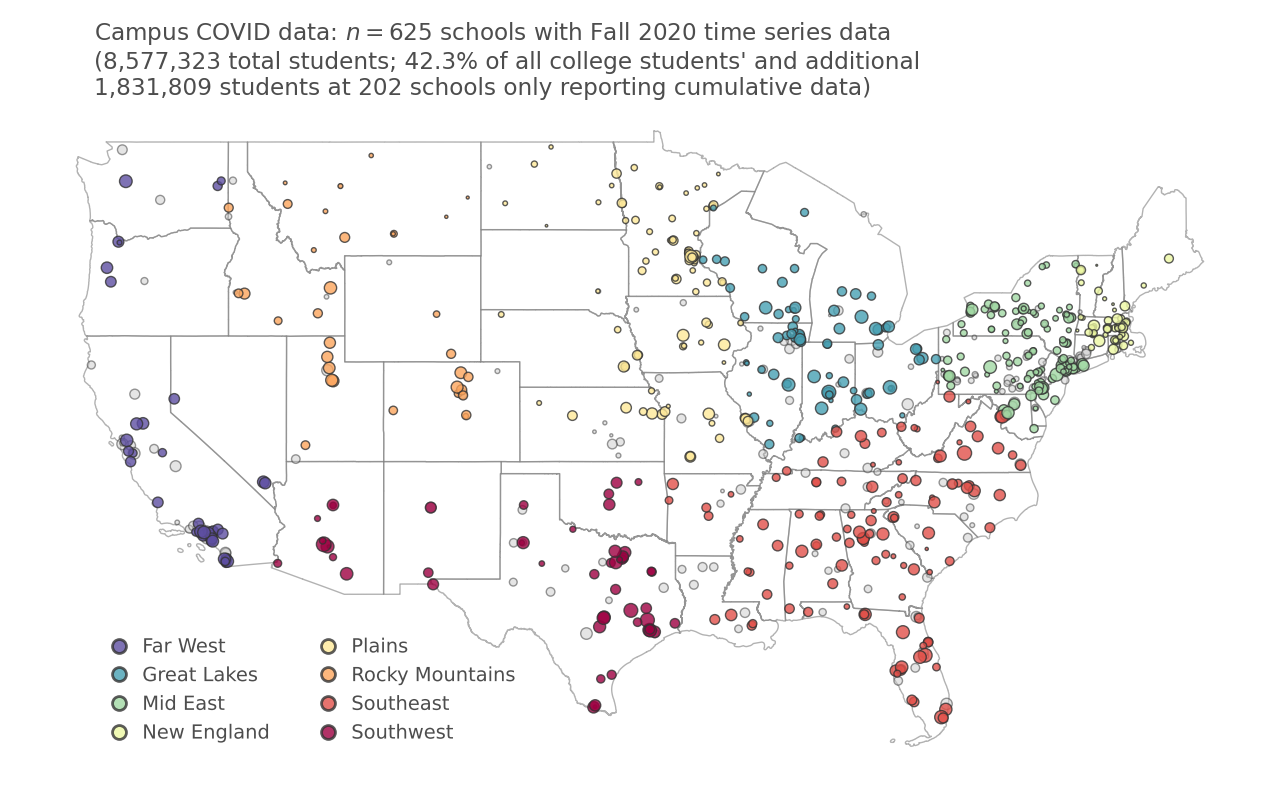

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=200)

mapplot_i = dat_shp.plot(ax=ax, ec='0.5', fc='None', lw=0.5, alpha=0.6)
mapplot_i.set_rasterized(True)

ylims = ax.get_ylim()
xlims = ax.get_xlim()

geo_dfx.plot(ax=ax,c='.8',lw=0.5,ec='.2',alpha=0.5,
            markersize=((np.log(geo_dfx['enrollment_total'])**5)/7000))

xx.plot(ax=ax,column='region',cmap='Spectral_r',lw=0.5,ec='.2',alpha=0.8,
        markersize=((np.log(xx['enrollment_total'])**5)/7000), legend=True,
        legend_kwds={'loc':3,'bbox_to_anchor':[0.05,0.025],'fontsize':7,
                     'ncol':2,'markerscale':0.5,'framealpha':0,
                     'handletextpad':0.2})
for legend_handle in ax.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('.2')

ax.set_ylim(ylims[0],ylims[1])
ax.set_xlim(xlims[0],xlims[1])
l = ax.get_legend()
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])



percent_total_i = np.round(geo_df['enrollment_total'].sum()/ipeds_df['enrollment_total'].sum(),4)*100
ax.set_title("Campus COVID data: $n=%i$ schools with Fall 2020 time series data"%times_df['ipeds_id'].nunique()+\
             "\n(%s total students; %.1f%% of all college students' and additional"%(
                    "{:,}".format(int(geo_df['enrollment_total'].sum())),
                    percent_total_i)+\
         "\n%s students at %i schools only reporting cumulative data)"%("{:,}".format(
            int(geo_dfx['enrollment_total'].sum())),geo_dfx.shape[0]),
             fontsize='small', color='.3', pad=-5, loc='left', x=0.06)
ax.set_axis_off()

plt.savefig('../figs/pngs/maps_so_far.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/maps_so_far.pdf',dpi=425,bbox_inches='tight')
plt.show()

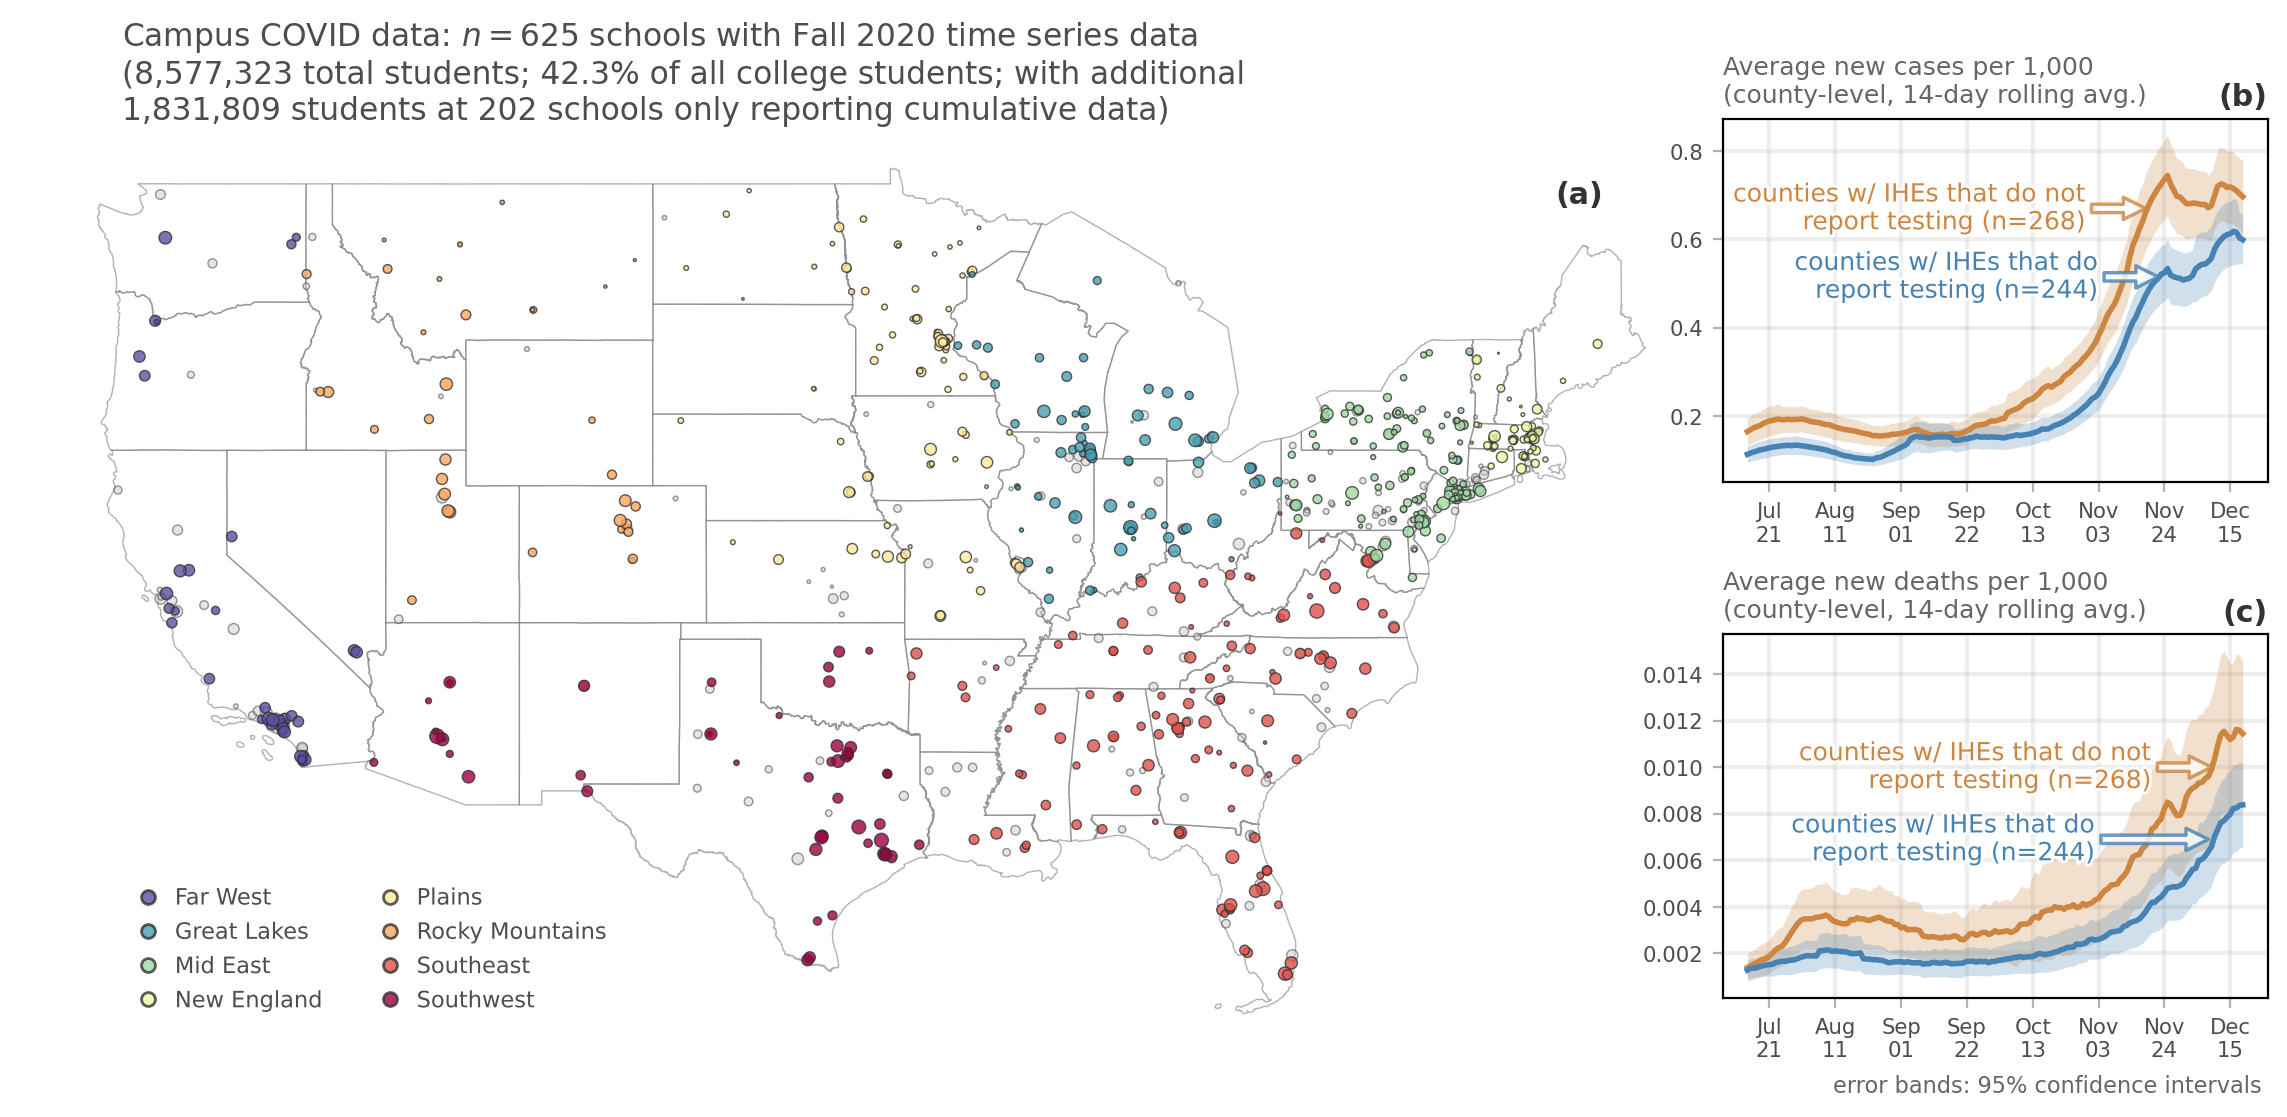

In [21]:
fig = plt.figure(figsize=(14.5,6.25),dpi=200)
gs = fig.add_gridspec(nrows=4, ncols=7,
                      height_ratios=[1,0.1,1,0.02], width_ratios=[1,1,1,1,1,0.6,1])

fs = 9

ax1 = fig.add_subplot(gs[:,0:5])
ax2 = fig.add_subplot(gs[0:1,5:])
ax3 = fig.add_subplot(gs[2:3,5:])

mapplot_i = dat_shp.plot(ax=ax1, ec='0.5', fc='None', lw=0.5, alpha=0.6)
mapplot_i.set_rasterized(True)

ylims = ax1.get_ylim()
xlims = ax1.get_xlim()

geo_dfx.plot(ax=ax1,c='.8',lw=0.5,ec='.2',alpha=0.5,
            markersize=((np.log(geo_dfx['enrollment_total'])**5)/7000))

xx.plot(ax=ax1,column='region',cmap='Spectral_r',lw=0.5,ec='.2',alpha=0.8,
        markersize=((np.log(xx['enrollment_total'])**5)/7000), legend=True,
        legend_kwds={'loc':3,'bbox_to_anchor':[0.05,0.025],'fontsize':fs*0.9,
                     'ncol':2,'markerscale':0.5,'framealpha':0,
                     'handletextpad':0.2})
for legend_handle in ax1.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('.2')

ax1.set_ylim(ylims[0],ylims[1])
ax1.set_xlim(xlims[0],xlims[1])
l = ax1.get_legend()
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])



percent_total_i = np.round(geo_df['enrollment_total'].sum()/ipeds_df['enrollment_total'].sum(),4)*100
ax1.set_title(
    "Campus COVID data: $n=%i$ schools with Fall 2020 time series data"%times_df['ipeds_id'].nunique()+\
             "\n(%s total students; %.1f%% of all college students; with additional"%(
                    "{:,}".format(int(geo_df['enrollment_total'].sum())),
                    percent_total_i)+\
         "\n%s students at %i schools only reporting cumulative data)"%("{:,}".format(
            int(geo_dfx['enrollment_total'].sum())),geo_dfx.shape[0]),
             fontsize=fs*1.25, color='.3', pad=-5, loc='left', x=0.06)
ax1.set_axis_off()

yes_col = 'steelblue'
non_col = 'peru'
wid = 14
x_yes_death = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in ll_yes_death['date'].values]
x_non_death = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in ll_non_death['date'].values]
x_yes_cases = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in ll_yes_cases['date'].values]
x_non_cases = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in ll_non_cases['date'].values]

yestest_lab = 'counties w/ IHEs that do\nreport testing (n=%i)'%len(yestest_fips)
nontest_lab = 'counties w/ IHEs that do not\nreport testing (n=%i)'%len(nontest_fips)

ax2.plot(x_non_cases, ll_non_cases['nanmean'].rolling(window=wid).mean().values, color=non_col,lw=2)
ax2.plot(x_yes_cases, ll_yes_cases['nanmean'].rolling(window=wid).mean().values, color=yes_col,lw=2)
ax3.plot(x_non_death, ll_non_death['nanmean'].rolling(window=wid).mean().values, color=non_col,lw=2)
ax3.plot(x_yes_death, ll_yes_death['nanmean'].rolling(window=wid).mean().values, color=yes_col,lw=2)

ax2.fill_between(x_non_cases, ll_non_cases['ci95_lo'].rolling(window=wid).mean().values,
             ll_non_cases['ci95_hi'].rolling(window=wid).mean().values, alpha=0.25,color=non_col, lw=0)
ax2.fill_between(x_yes_cases, ll_yes_cases['ci95_lo'].rolling(window=wid).mean().values,
             ll_yes_cases['ci95_hi'].rolling(window=wid).mean().values, alpha=0.25,color=yes_col, lw=0)
ax3.fill_between(x_non_death, ll_non_death['ci95_lo'].rolling(window=wid).mean().values,
             ll_non_death['ci95_hi'].rolling(window=wid).mean().values, alpha=0.25,color=non_col, lw=0)
ax3.fill_between(x_yes_death, ll_yes_death['ci95_lo'].rolling(window=wid).mean().values,
             ll_yes_death['ci95_hi'].rolling(window=wid).mean().values, alpha=0.25,color=yes_col, lw=0)

ax2.annotate(nontest_lab, xy=(x_non_cases[-32], 0.67), xytext=(x_non_cases[-51], 0.67),
             arrowprops=dict(fc='w', ec=non_col, width=3, lw=1.25, headwidth=8, headlength=8, alpha=0.8),
             ha='right',va='center',fontsize=fs*1.0,color=non_col,zorder=2,
             path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Normal()])
ax2.annotate(yestest_lab, xy=(x_yes_cases[-28], 0.515), xytext=(x_yes_cases[-47], 0.515),
             arrowprops=dict(fc='w', ec=yes_col, width=3, lw=1.25, headwidth=8, headlength=8, alpha=0.8),
             ha='right',va='center',fontsize=fs*1.0,color=yes_col,zorder=2,
             path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Normal()])
ax3.annotate(nontest_lab, xy=(x_non_cases[-11], 0.010), xytext=(x_non_cases[-30], 0.010),
             arrowprops=dict(fc='w', ec=non_col, width=3, lw=1.25, headwidth=8, headlength=8, alpha=0.8),
             ha='right',va='center',fontsize=fs*1.0,color=non_col,zorder=2,
             path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Normal()])
ax3.annotate(yestest_lab, xy=(x_yes_cases[-12], 0.0069), xytext=(x_yes_cases[-48], 0.0069),
             arrowprops=dict(fc='w', ec=yes_col, width=3, lw=1.25, headwidth=8, headlength=8, alpha=0.8),
             ha='right',va='center',fontsize=fs*1.0,color=yes_col,zorder=2,
             path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Normal()])

ax2.set_title('Average new cases per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.4',x=0,ha='left', fontsize=fs)
ax3.set_title('Average new deaths per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.4',x=0,ha='left', fontsize=fs)
ax3.text(0.99, -0.21, 'error bands: 95% confidence intervals', ha='right', va='top',
           transform=ax3.transAxes, color='.4', fontsize=fs*0.9)

ax1.text(0.93, 0.91, "(a)", ha='right', va='bottom', transform=ax1.transAxes,
       fontweight='bold', fontsize=fs*1.2, color='.2')
letts = ["(b)","(c)"]
for ai, a in enumerate([ax2,ax3]):
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.set_xticks(x_yes_death[20::21])
    a.set_xticklabels(["{:%b\n%d}".format(i) for i in x_yes_death[20::21]])
    a.tick_params(labelcolor='.3',color='.7',labelsize=fs*0.85)
    a.text(1.0, 1.02, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize=fs*1.2, color='.2')

plt.subplots_adjust(wspace=0.0,hspace=0.3)

plt.savefig('../figs/pngs/map_with_testing_comparison.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/map_with_testing_comparison.pdf',dpi=425,bbox_inches='tight')

plt.show()

In [22]:
yestest_info_df = ll.loc[ll['fips'].isin(yestest_fips)][['fips','county_population']].drop_duplicates()
nontest_info_df = ll.loc[ll['fips'].isin(nontest_fips)][['fips','county_population']].drop_duplicates()
yestest_info_df['testing'] = 'yes_test'
nontest_info_df['testing'] = 'non_test'

info_df = pd.concat([yestest_info_df,nontest_info_df]).reset_index().iloc[:,1:]

In [23]:
date_dict = dict(zip(sorted(ll['date'].unique()), list(range(ll['date'].nunique()))))

In [24]:
prior_to_date = '2020-07-30'
ll_pre = ll.loc[ll['date']<=prior_to_date].copy()
max_events_pre = ll_pre.groupby('fips').agg({'new_cases_county':'max',
                                             'new_deaths_county':'max'}).reset_index()
max_events_pre['max_cases_date'] = prior_to_date
max_events_pre['max_deaths_date'] = prior_to_date

for f in max_events_pre['fips'].values:
    nc_i = max_events_pre.loc[max_events_pre['fips']==f]['new_cases_county'].values[0]
    nd_i = max_events_pre.loc[max_events_pre['fips']==f]['new_deaths_county'].values[0]

    if nc_i > 0:
        nc_d = ll_pre.loc[(ll_pre['fips']==f)&(ll_pre['new_cases_county']==nc_i)]['date'].values[0]
        max_events_pre.loc[max_events_pre['fips']==f, 'max_cases_date'] = nc_d

    if nd_i > 0:
        nd_d = ll_pre.loc[(ll_pre['fips']==f)&(ll_pre['new_deaths_county']==nd_i)]['date'].values[0]
        max_events_pre.loc[max_events_pre['fips']==f, 'max_deaths_date'] = nd_d

In [25]:
max_events_pre['max_cases_datenum'] = [date_dict[i] for i in max_events_pre['max_cases_date']]
max_events_pre['max_deaths_datenum'] = [date_dict[i] for i in max_events_pre['max_deaths_date']]

In [26]:
info_df = info_df.merge(max_events_pre[['fips','max_cases_datenum','max_deaths_datenum']],how='left',on='fips')

In [27]:
prior_maxcases = get_ci(info_df, 'max_cases_datenum', 'testing').reset_index()
prior_maxdeath = get_ci(info_df, 'max_deaths_datenum', 'testing').reset_index()

In [28]:
yestest_max_cases = prior_maxcases.loc[prior_maxcases['testing']=='yes_test'].copy()
nontest_max_cases = prior_maxcases.loc[prior_maxcases['testing']=='non_test'].copy()

yestest_max_death = prior_maxdeath.loc[prior_maxdeath['testing']=='yes_test'].copy()
nontest_max_death = prior_maxdeath.loc[prior_maxdeath['testing']=='non_test'].copy()

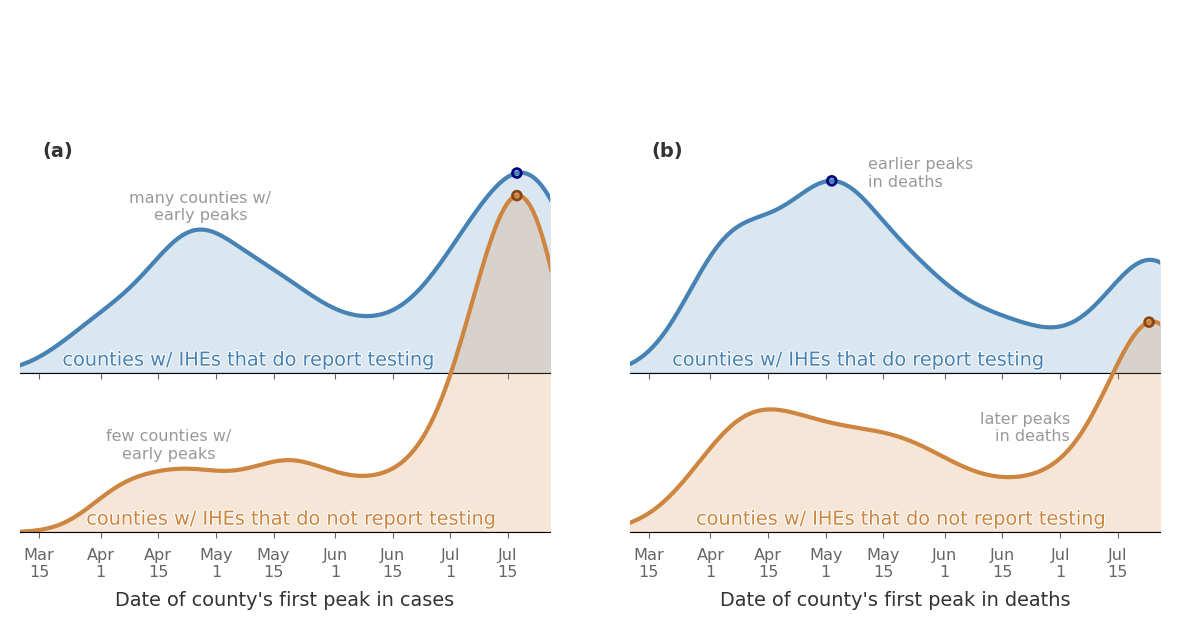

In [29]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(2,2,figsize=(6,2.5),dpi=200,sharex=True,sharey=True)

density = gaussian_kde(info_df.loc[info_df['testing']=='yes_test']['max_cases_datenum'].values)
xs = np.linspace(0,max(info_df['max_cases_datenum']),200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax[(0,0)].plot(xs,density(xs),color=yes_col)
ax[(0,0)].fill_between(xs,density(xs),alpha=0.2,color=yes_col)
ax[(0,0)].scatter(xs[185],density(xs)[185],ec='navy',fc='none',zorder=15,s=10)
ax[(0,0)].scatter(xs[185],density(xs)[185],ec='none',alpha=0.35,fc=yes_col,zorder=14,s=10)

density = gaussian_kde(info_df.loc[info_df['testing']!='yes_test']['max_cases_datenum'].values)
xs = np.linspace(0,max(info_df['max_cases_datenum']),200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax[(1,0)].plot(xs,density(xs),color=non_col)
ax[(1,0)].fill_between(xs,density(xs),alpha=0.2,color=non_col)
ax[(1,0)].scatter(xs[185],density(xs)[185],ec='saddlebrown',fc='none',zorder=15,s=10)
ax[(1,0)].scatter(xs[185],density(xs)[185],ec='none',alpha=0.35,fc=non_col,zorder=14,s=10)

density = gaussian_kde(info_df.loc[info_df['testing']=='yes_test']['max_deaths_datenum'].values)
xs = np.linspace(0,max(info_df['max_cases_datenum']),200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax[(0,1)].plot(xs,density(xs),color=yes_col)
ax[(0,1)].fill_between(xs,density(xs),alpha=0.2,color=yes_col)
ax[(0,1)].scatter(xs[93],density(xs)[93],ec='navy',fc='none',zorder=15,s=10)
ax[(0,1)].scatter(xs[93],density(xs)[93],ec='none',alpha=0.35,fc=yes_col,zorder=14,s=10)

density = gaussian_kde(info_df.loc[info_df['testing']!='yes_test']['max_deaths_datenum'].values)
xs = np.linspace(0,max(info_df['max_cases_datenum']),200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax[(1,1)].plot(xs,density(xs),color=non_col)
ax[(1,1)].fill_between(xs,density(xs),alpha=0.2,color=non_col)
ax[(1,1)].scatter(xs[192],density(xs)[192],ec='saddlebrown',fc='none',zorder=15,s=10)
ax[(1,1)].scatter(xs[192],density(xs)[192],ec='none',alpha=0.35,fc=non_col,zorder=14,s=10)

yestest_lab = 'counties w/ IHEs that do report testing'# (n=%i)'%len(yestest_fips)
nontest_lab = 'counties w/ IHEs that do not report testing'# (n=%i)'%len(nontest_fips)
ax[(0,0)].text(0.08,0.01, yestest_lab, ha='left', va='bottom',
               transform=ax[(0,0)].transAxes,color=yes_col,fontsize='x-small',
               path_effects=[path_effects.Stroke(linewidth=0.7, foreground='w'),path_effects.Normal()])
ax[(0,1)].text(0.08,0.01, yestest_lab, ha='left', va='bottom',
               transform=ax[(0,1)].transAxes,color=yes_col,fontsize='x-small',
               path_effects=[path_effects.Stroke(linewidth=0.7, foreground='w'),path_effects.Normal()])
ax[(1,0)].text(0.125,0.01, nontest_lab, ha='left', va='bottom',
               transform=ax[(1,0)].transAxes,color=non_col,fontsize='x-small',
               path_effects=[path_effects.Stroke(linewidth=0.7, foreground='w'),path_effects.Normal()])
ax[(1,1)].text(0.125,0.01, nontest_lab, ha='left', va='bottom',
               transform=ax[(1,1)].transAxes,color=non_col,fontsize='x-small',
               path_effects=[path_effects.Stroke(linewidth=0.7, foreground='w'),path_effects.Normal()])

spines = ["top","right","left"]
for ai,a in enumerate(fig.axes):
    a.tick_params(labelcolor='.4',color='.4',length=2,width=0.4)
    a.set_ylim(0)
    a.patch.set_alpha(0)
    a.set_yticks([])
    a.set_xticks([30,46,61,76,91,107,122,137,152])
    a.set_xticklabels(['Mar\n15','Apr\n1','Apr\n15','May\n1','May\n15',
                       'Jun\n1','Jun\n15','Jul\n1','Jul\n15'],fontsize='xx-small')
    a.set_xlim(25,163)
    a.spines['bottom'].set_linewidth(0.4)
    for s in spines:
        a.spines[s].set_visible(False)

ax[(1,0)].set_xlabel("Date of county's first peak in cases",fontsize='x-small',color='.2')
ax[(1,1)].set_xlabel("Date of county's first peak in deaths",fontsize='x-small',color='.2')
ax[(0,0)].text(0.1, 0.6, '(a)', ha='right', va='bottom', transform=ax[(0,0)].transAxes,
           fontweight='bold', fontsize='x-small', color='.2')
ax[(0,1)].text(0.1, 0.6, '(b)', ha='right', va='bottom', transform=ax[(0,1)].transAxes,
           fontweight='bold', fontsize='x-small', color='.2')
ax[(0,0)].text(0.34, 0.425, 'many counties w/\nearly peaks', ha='center', va='bottom',
               transform=ax[(0,0)].transAxes, fontsize='xx-small', color='.6')
ax[(1,0)].text(0.28, 0.2, 'few counties w/\nearly peaks', ha='center', va='bottom',
               transform=ax[(1,0)].transAxes, fontsize='xx-small', color='.6')
ax[(0,1)].text(0.45, 0.52, 'earlier peaks\nin deaths', ha='left', va='bottom',
               transform=ax[(0,1)].transAxes, fontsize='xx-small', color='.6')
ax[(1,1)].text(0.83, 0.25, 'later peaks\nin deaths', ha='right', va='bottom',
               transform=ax[(1,1)].transAxes, fontsize='xx-small', color='.6')


plt.subplots_adjust(hspace=-0.55, wspace=0.15, left=0.025, right=0.975, bottom=0.175, top=1.2)

plt.savefig('../figs/pngs/peak_cases_and_deaths_yestest_nontest.png',dpi=425)
plt.savefig('../figs/pdfs/peak_cases_and_deaths_yestest_nontest.pdf')

plt.show()